Notebook used to train models
 - used to train the origional model

In [ ]:
#select a channel to operate on
ch = 42

In [ ]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
#import shap
#shap.initjs()

import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
#possibly worth using the below 
#tf.compat.v1.enable_eager_executionconfig=None, device_policy=None, execution_mode=None)
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json

from tensorflow.keras.callbacks import CSVLogger

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

#r2 score
#from keras import backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

#model optimisation api
#import tensorflow_model_optimization as tfmot

import tempfile
import os
import zipfile

%load_ext tensorboard

from tabulate import tabulate

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.metrics = []
        self.val_metrics = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('r_squared'))
        self.val_acc.append(logs.get('val_r_squared'))
        ###
        self.metrics.append(logs.get('mean_absolute_percentage_error'))         #mean_squared_error
        self.val_metrics.append(logs.get('val_mean_absolute_percentage_error')) #val_mean_squared_error
        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(60, 20))
        plt.plot([3, 1])

        #plot 1 mean absolute percentage error
        plt.subplot(131) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('Mse')
        plt.xlabel('epoch')
        plt.title('MSE Value')
        plt.legend()

        #plot 2 r squared value
        plt.subplot(133)         
        plt.plot(self.x, self.acc, label="training r-squared")
        plt.plot(self.x, self.val_acc, label="validation r-squared")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('R-squared')
        plt.xlabel('epoch')
        plt.title('R-Squared Value')

        #plot 3 mean squared error
        plt.subplot(132)         
        plt.plot(self.x, self.metrics, label="training mse")
        plt.plot(self.x, self.val_metrics, label="validation mse")
        plt.legend()
        plt.ylabel('Mean absolute percentage Error')
        plt.xlabel('epoch')
        plt.title('Mean absolute percentage Error')
        
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        

#creating a r^2 metric for the model evaluation
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    

In [ ]:
#create a list of channel names 
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [ ]:
#generate the train and validation datasets
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df_x = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names)

df_y = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names)

#dropping the frequences row for each training sample
df_x = df_x.iloc[1::2]
#print(df_x)

In [ ]:
#drop all rows where df_x has a value != 0
df_chx = df_x[df_x[ch_names[ch]] !=0].iloc[500:,:]
df_chy = df_y[df_y[ch_names[ch]] !=0].iloc[500:,:]
df_chy = df_chy[ch_names[ch]]

#convert to numpy arrays
x_values = df_chx.to_numpy()
y_values = df_chy.to_numpy()

#adding some samples where the channel is 0
#x values
df_xzero = df_x.iloc[:500,:]
x_values = np.concatenate((x_values, df_xzero.to_numpy()), axis=0)

#y values
df_yzero = df_y.iloc[:500,ch]
y_values = np.concatenate((y_values, df_yzero.to_numpy()), axis=0)


#generate the test/validation split
val_split = .2
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size = val_split, random_state = 0)#renaimed x_rem and y_rem to x_values and y_values


In [ ]:
print(x_train.shape[0])

5034


In [ ]:
#create the models
inputs = keras.layers.Input(shape=(44,))


x = Dense(360, activation='relu', name='1_dense' )(inputs)
x = Dropout(0.45)(x) # Drop out
x = Dense(180, activation='linear', name='2_dense')(x)
x = Dropout(0.45)(x) # Drop out
x = Dense(180, activation='relu', name='3_dense')(x)
x = Dropout(0.45)(x) # Drop out 
x = Dense(90, activation='linear', name='4_dense')(x)
x = Dropout(0.4)(x) # Drop out
x = Dense(45, activation='relu', name='5_dense')(x)
x = Dropout(0.2)(x) # Drop out 
predictions = Dense(1, activation='relu', name='6_dense')(x)

l_rate = 1 * 1e-4

# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = tf.keras.optimizers.Nadam(learning_rate=l_rate)

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',      #formerly mean_absolute_percentage_error
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()]) #tf.keras.metrics.MeanAbsolutePercentageError()


model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 44)]              0         
_________________________________________________________________
1_dense (Dense)              (None, 360)               16200     
_________________________________________________________________
dropout_70 (Dropout)         (None, 360)               0         
_________________________________________________________________
2_dense (Dense)              (None, 180)               64980     
_________________________________________________________________
dropout_71 (Dropout)         (None, 180)               0         
_________________________________________________________________
3_dense (Dense)              (None, 180)               32580     
_________________________________________________________________
dropout_72 (Dropout)         (None, 180)               0  

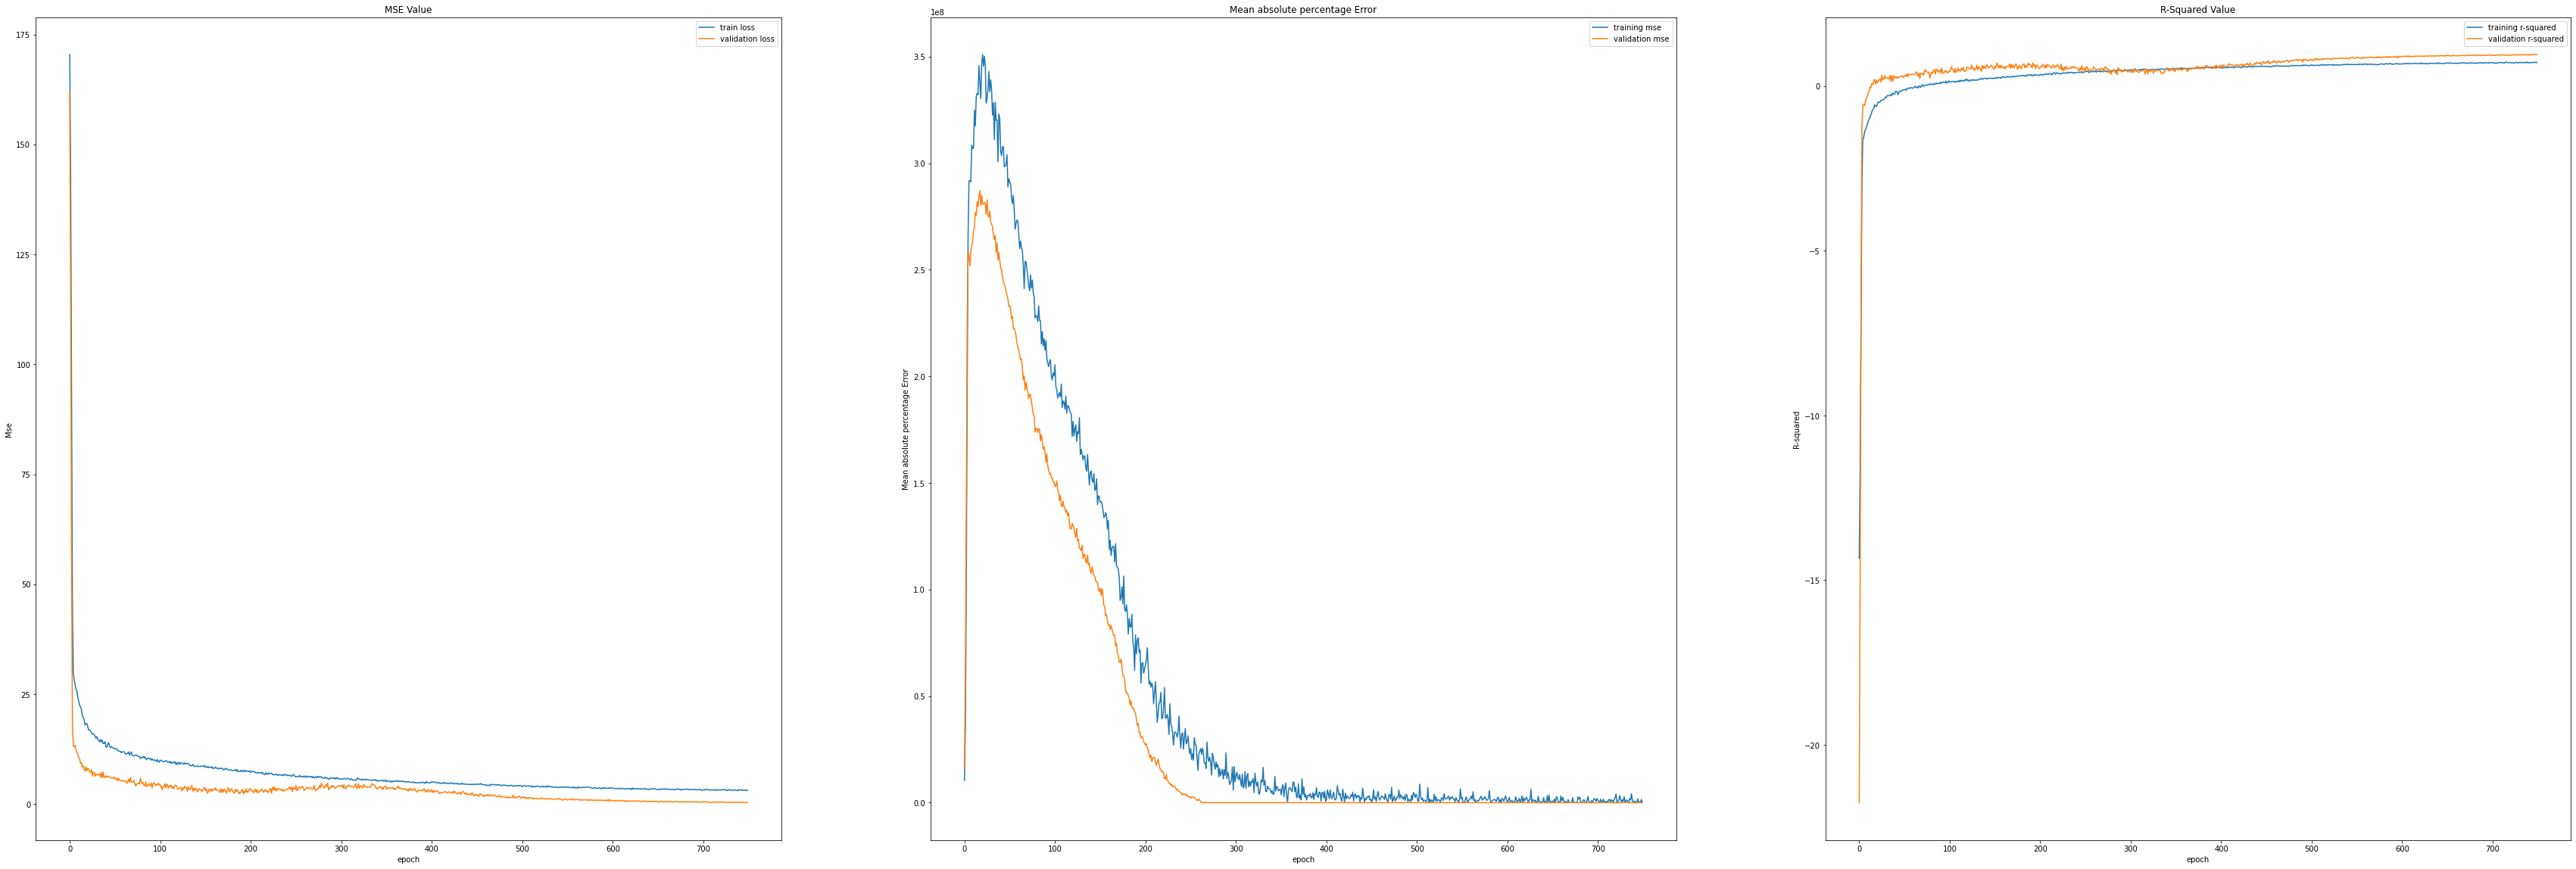


Epoch 00750: val_loss did not improve from 0.30823


In [ ]:
#callback for plotting the model metrics
#path = "checkpoint4/"
file_name = "checkpoint/ch_{0}.ckpt".format(ch)
log_file = "model_ch_{0}.csv".format(ch)
csv_log = CSVLogger(log_file)

pltCallBack = PlotLossAccuracy()
#callback for saving the model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= file_name, #path + file_name + "ep_{epoch:02d}_mse_{val_loss:.2f}_pct_err_{val_mean_absolute_percentage_error:.2f}.ckpt", #
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_freq="epoch",
                                                  save_weights_only=False,
                                                  save_best_only=True,
                                                  mode='min')

batchSize = 400

# and train
model.fit(x_train, y_train,
                    batch_size=batchSize, epochs=750,   #500 ephocs gives ~ 5% error
                    validation_data=(x_val, y_val), 
                    callbacks=[pltCallBack, checkpoint_callback, csv_log])

In [ ]:
#print the logfile of the model training data
pd.read_csv(log_file, index_col='epoch')


,loss,mean_absolute_percentage_error,r_squared,val_loss,val_mean_absolute_percentage_error,val_r_squared
epoch,,,,,,
0,170.457764,1.053886e+07,-14.337286,161.946838,1.612594e+07,-21.756891
1,144.640686,3.531027e+07,-11.575817,116.387154,5.957822e+07,-15.248330
2,94.688942,9.999300e+07,-7.405353,56.447323,1.348096e+08,-6.701585
3,44.995872,1.928174e+08,-2.916032,17.874016,2.264488e+08,-1.226057
4,29.835192,2.662733e+08,-1.618084,13.183305,2.584019e+08,-0.573492
...,...,...,...,...,...,...
745,3.183011,1.040371e+01,0.715785,0.361638,3.634677e+00,0.955333
746,3.193346,3.558029e+05,0.718528,0.339733,3.503410e+00,0.957812
747,3.028404,2.106057e+05,0.734347,0.308229,3.300729e+00,0.962311


In [ ]:
#model testing
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub



git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/const_ch/ch{0}/x_val.csv'.format(ch))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/const_ch/ch{0}/y_val.csv'.format(ch)) #need to replace number with ch varble
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )

#dropping the frequences row for each training sample
dfx = dfx.iloc[1::2]

#drop all rows where df_x has a value != 0
dfx = dfx[dfx[ch_names[ch]] !=0]
dfy = dfy[dfy[ch_names[ch]] !=0]
dfy = dfy[ch_names[ch]]

x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

In [ ]:
#evaluate the model on the test set
results = model.evaluate(x_test,y_test)#, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {percent_err:<.3%}\t(lower is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[2],
                                                                                                    mse = results[0],
                                                                                                    percent_err = results[2]/100))

25/25 [==============================] - 0s 2ms/step - loss: 0.5219 - r_squared: 0.9255 - mean_absolute_percentage_error: 4.9309
loss		: 0.5219	(lower is better)
mean_absolute_percentage_error	: 4.931%	(lower is better)


In [ ]:
#downloading the model
#changes the model from the model checkpoint filetype to keras h5 filetype
export_model = tf.keras.models.load_model(file_name,
                                          custom_objects={'r_squared': r_squared})
export_model.compile(optimizer=opt,
              loss='mean_squared_error',      #formerly mean_absolute_percentage_error
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])

num_epochs = pd.read_csv(log_file, index_col='epoch').shape[0]


export_dir = "model_exports/ch_{0}_ep_{1}_pct_err_{c:.1f}_mse_{b:.1f}_.h5".format(ch, num_epochs, b = results[0], c = results[2])
export_model.save(export_dir)
files.download(export_dir)


#download the training log
new_name = "ch{0}_training_log_ep{1}_pct_err{c:.1f}_mse{b:.1f}.csv".format(ch, num_epochs, b = results[0], c = results[2])
os.rename(log_file, new_name)
files.download(new_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#loading a previously saved model
"""
model_dir = "ch_14_ep_500_pct_err_5.2_mse_0.0_.h5"
l_rate = 1 * 1e-4

model = tf.keras.models.load_model(model_dir, custom_objects={'r_squared': r_squared})
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=l_rate),
              loss='mean_squared_error',
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])

model.summary()
"""

'\nmodel_dir = "ch_14_ep_500_pct_err_5.2_mse_0.0_.h5"\nl_rate = 1 * 1e-4\n\nmodel = tf.keras.models.load_model(model_dir, custom_objects={\'r_squared\': r_squared})\nmodel.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=l_rate),\n              loss=\'mean_squared_error\',\n              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])\n\nmodel.summary()\n'

In [ ]:
#evaluating the loaded model
"""

results = model.evaluate(x_test,y_test)#, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {percent_err:<.3%}\t(lower is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[2],
                                                                                                    mse = results[0],
                                                                                                    percent_err = results[2]/100))

"""

'\n\nresults = model.evaluate(x_test,y_test)#, verbose=1)\nprint("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {percent_err:<.3%}\t(lower is better)".format(name1 = model.metrics_names[0],\n                                                                                                    name2 = model.metrics_names[2],\n                                                                                                    mse = results[0],\n                                                                                                    percent_err = results[2]/100))\n\n'